# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. **Refine lattice vectors**
6. Calculate strain
7. Visualize strain maps

# Notebook 5: Refine lattice vectors

In this step the lattice vectors are refined by performing an interative, weighted fit to the measured Bragg peaks.

* For one, typical diffraction pattern:
    * Get the list of Bragg peaks
    * Determine the Bragg peak indices using the initial u,v guess
    * Iteratively: recalculate u,v values, recalculate Bragg peak indices
    * Get final u,v
* For each diffraction pattern:
    * Get the list of Bragg peaks
    * Ignore if there are insufficient peaks
    * Determine the Bragg peak indices using the initial u,v guess
    * Iteratively: recalculate u,v values, recalculate Bragg peak indices
    * Get final u,v

### Some formalism

The approach here is to iteratively solve the system of linear equations:

\begin{align*}
a \cdot u_x + b \cdot v_x = g^{ab}_x \\
a \cdot u_y + b \cdot v_y = g^{ab}_y
\end{align*}

where $a$ and $b$ are integers which index the diffraction peaks, $\mathbf{u} = u_x + u_y$ and $\mathbf{v} = v_x + v_y$ are the lattice vectors, and $\mathbf{g}^{ab} = g^{ab}_x + g^{ab}_y$ is the measured bragg peak at index $(a,b)$.

Equivalently, written as a matrix equation of the form $M\beta = \alpha$:
\begin{equation}
\begin{pmatrix}
&\vdots& \\
a   & &   b   \\
&\vdots&
\end{pmatrix}
\begin{pmatrix}
u_x   &   u_y   \\
v_x   &   v_y
\end{pmatrix}
=
\begin{pmatrix}
&\vdots& \\
g^{ab}_x   & &   g^{ab}_y   \\
&\vdots&
\end{pmatrix}
\end{equation}

Here, $\beta$ is the $2\times2$ lattice vector matrix, $\alpha$ is the $N_{\text{peaks}}\times2$ matrix of measured Bragg peak positions, and $M$ is the $N_{\text{peaks}}\times2$ matrix of Bragg peak indices.

### The approach here

At this point, we have the measured Bragg peak positions $\alpha$, and an initial guess at the lattice vectors $\beta$.

For each diffration pattern, we'll:
* Determine the indices $M$ corresponding to the observed Bragg peak positions, given our initial guess at the lattice vectors.
* Given this matrix of indices $M$ and the measure Bragg peak positions $\alpha$, we'll recalculate the lattice vectors that best the solve system of equations.  This time, we'll weight the importance of each measured Bragg peak position according to its cross correlation intensity.
* Iterate the prior two steps several times

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit
from time import time
from gc import collect
from numpy.linalg import solve

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList

/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
# Load the raw data
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_diffraction_shift_corrected.h5"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(60,60)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_diffraction_shift_corrected.h5...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_diffraction_shift_corrected.h5 is a py4DSTEM HDF5 file.  Reading...


In [9]:
# # Load the raw data
# fp = "/home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
# dc = py4DSTEM.readwrite.read_data_v0_1(fp)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

In [10]:
# Load corrected Bragg peaks list
fp_Braggpeaks = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
browser.show_dataobjects()
Bragg_peaks = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    pointlist_0                         PointList           


In [11]:
# # Load corrected Bragg peaks list
# fp_Braggpeaks = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
# browser.show_dataobjects()
# Bragg_peaks = browser.get_dataobject(0)

In [12]:
# Load the lattice vectors
fp_latticevectors = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_latticevectors)
browser.show_dataobjects()
lattice_vectors = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    lattice_vectors                     PointList           


In [13]:
# # Load the lattice vectors
# fp_latticevectors = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_latticevectors)
# browser.show_dataobjects()
# lattice_vectors = browser.get_dataobject(0)

In [15]:
# Load the deconvolution
fp_deconvolution = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_deconvolution)
browser.show_dataobjects()
deconvolution = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    diffractionslice_0                  DiffractionSlice    


In [14]:
# # Load the deconvolution
# fp_deconvolution = "/home/ben/Data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_deconvolution)
# browser.show_dataobjects()
# deconvolution = browser.get_dataobject(0)

### Get the list of Bragg peaks

In [16]:
# Select DP, get the Bragg peaks for this DP, filter low intensity peaks

rx,ry = 30,30
minRelativeIntensity = 0.02

Bragg_peaks_current_DP = Bragg_peaks.get_subpointlist([('rx',rx),('ry',ry)])
deletemask = Bragg_peaks_current_DP.data['intensity']/max(Bragg_peaks_current_DP.data['intensity']) < minRelativeIntensity
Bragg_peaks_current_DP.remove_points(deletemask)

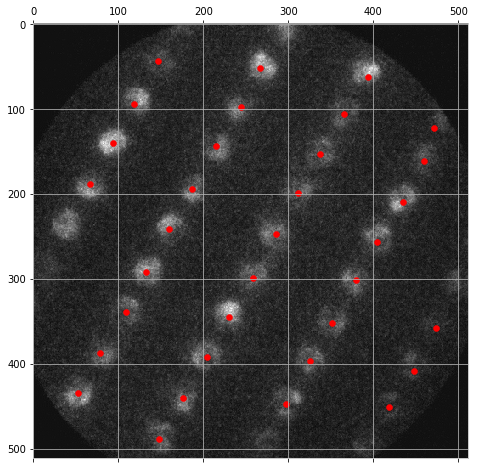

In [17]:
# Show

DP = dc.data4D[ry,rx,:,:]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
plt.show()

### Determine the Bragg peak indices using the initial u,v guess

In [35]:
# Get the lattice vector matrix, beta

u_x = lattice_vectors.data['length'][0]*np.cos(lattice_vectors.data['angle'][0]*np.pi/180.)
u_y = lattice_vectors.data['length'][0]*np.sin(lattice_vectors.data['angle'][0]*np.pi/180.)
v_x = lattice_vectors.data['length'][1]*np.cos(lattice_vectors.data['angle'][1]*np.pi/180.)
v_y = lattice_vectors.data['length'][1]*np.sin(lattice_vectors.data['angle'][1]*np.pi/180.)


uv = np.array([[u_x, u_y],[v_x, v_y]])

In [36]:
# Get central peak

x_beam,y_beam = np.unravel_index(np.argmax(deconvolution.data2D),deconvolution.data2D.shape)

ind = np.argmin((Bragg_peaks_current_DP.data['qx']-x_beam)**2 + (Bragg_peaks_current_DP.data['qy']-y_beam)**2)
x0,y0 = Bragg_peaks_current_DP.data['qx'][ind],Bragg_peaks_current_DP.data['qy'][ind]

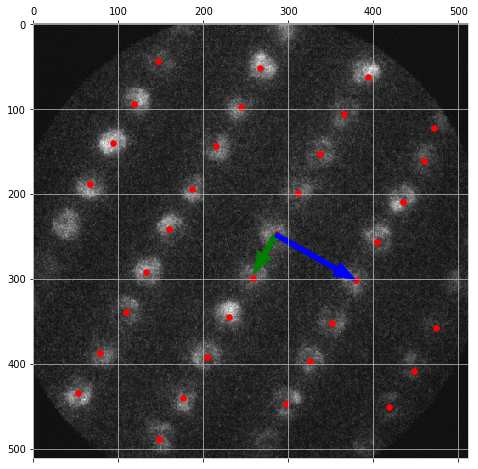

In [37]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_x,u_y, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_x,v_y, color='blue',width=6,length_includes_head=True)
plt.show()

In [46]:
# Get array of measured Bragg peak positions, using the central beam as the origin
x = Bragg_peaks_current_DP.data['qx'].reshape(Bragg_peaks_current_DP.length,1) - x_beam
y = Bragg_peaks_current_DP.data['qy'].reshape(Bragg_peaks_current_DP.length,1) - y_beam
Bragg_peak_positions = np.hstack((y,x))

#### A note on solving for $M$
Given an equation of the form $M\beta = \alpha$, the matrix equation solver numpy.linalg.solve will solve for $\beta$ given $M$ and $\alpha$.  So when solving for $M$, before passing it to the solver we need to rearrange the matrix equation at the beginning of the notebook as follows:

\begin{equation}
\begin{pmatrix}
u_x   &   v_x   \\
u_y   &   v_y
\end{pmatrix}
\begin{pmatrix}
& a & \\
\ldots   & &   \ldots   \\
&b&
\end{pmatrix}
=
\begin{pmatrix}
& g^{ab}_x & \\
\ldots   & &   \ldots   \\
& g^{ab}_y &
\end{pmatrix}
\end{equation}

Which is equivalent to
\begin{equation}
\beta^T M^T = \alpha^T
\end{equation}
where $A^T$ is the transpose of $A$.

In [58]:
# Get Bragg peak indices

M = solve(uv.T, Bragg_peak_positions.T).T
M = np.round(M)

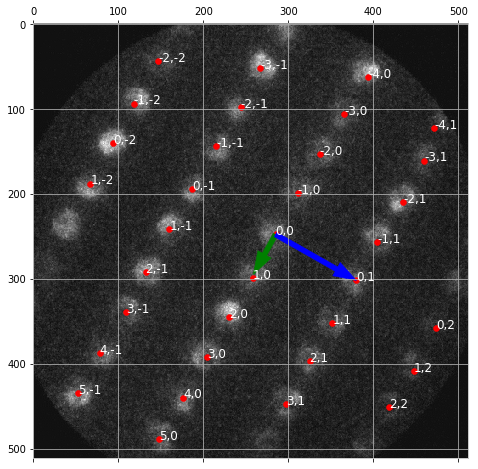

In [59]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_x,u_y, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_x,v_y, color='blue',width=6,length_includes_head=True)
for i in range(Bragg_peaks_current_DP.length):
    ax.text(Bragg_peaks_current_DP.data['qy'][i],Bragg_peaks_current_DP.data['qx'][i],
            '{},{}'.format(int(M[i,0]),int(M[i,1])),color='w',size=12)
plt.show()

### Refine lattice vectors

### Rotate, calculate projection, get projection maxima

In [10]:
# Get rotated coordinates

rotation_degrees = 30

theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

Bragg_peaks_rotated = Bragg_peaks_current_DP.copy()

for i in range(Bragg_peaks_current_DP.length):
    x0 = Bragg_peaks_current_DP.data['qx'][i]
    y0 = Bragg_peaks_current_DP.data['qy'][i]
    Bragg_peaks_rotated.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotated.data['qy'][i] = x0*sintheta + y0*costheta

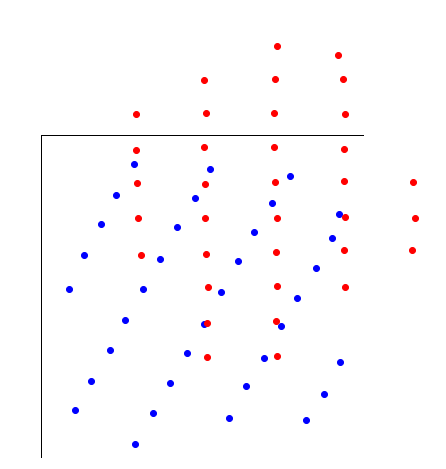

In [11]:
# Show

axis=np.ones_like(DP)
axis[0,:]=0
axis[:,0]=0

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(axis)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='b')
ax.scatter(Bragg_peaks_rotated.data['qy'],Bragg_peaks_rotated.data['qx'],color='r')
ax.axis('off')
plt.show()

In [12]:
# Calculate projected histograms

sigma_gaussianblur = 10

bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
projected_histogram = np.zeros_like(bins)
for i in range(Bragg_peaks_rotated.length):
    projected_histogram[int(Bragg_peaks_rotated.data['qx'][i])] += 1

histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)

In [13]:
# Get histogram maxima

min_dist = 10

maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))

coordinates = [('bin',int),('intensity',float)]
maxima = PointList(coordinates, dc)

for i in maxima0.nonzero()[0]:
    new_point = (bins[i], histogram_blurred[i])
    maxima.add_point(new_point)

maxima.sort('intensity')

deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if not deletemask[i]:
        delete = np.abs(maxima.data['bin'][i]-maxima.data['bin']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
maxima.remove_points(deletemask)


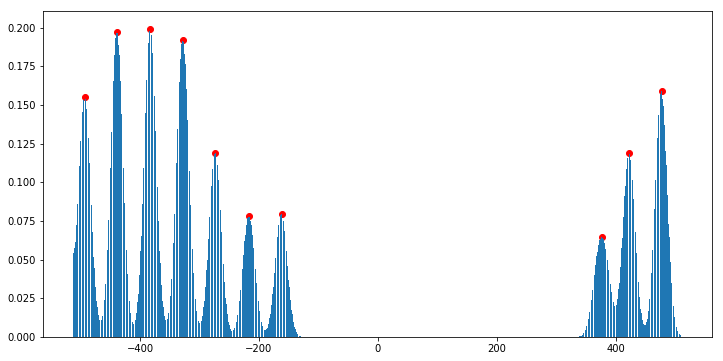

In [14]:
# Plot histograms

fig,ax = plt.subplots(figsize=(12,6))
ax.bar(bins, histogram_blurred)
ax.scatter(maxima.data['bin'],maxima.data['intensity'],color='r')
plt.show()

### Calculate the projection of the peaks as a function of rotation, from 0 to 180 degrees

In [142]:
# As a function of rotation angle, find number and intensity of histogram maxima

sigma_gaussianblur = 10
min_dist = 10
N_rotations = 100
threshhold = 0.05

# Rotating peaks list
Bragg_peaks_rotating = Bragg_peaks_current_DP.copy()
rotation_degrees = 180./N_rotations
angles = np.linspace(0,180,N_rotations,endpoint=False)
theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

# Metrics
N_maxima = np.empty_like(angles)
total_intensity = np.empty_like(angles)

t0=time()
for j in range(len(angles)):
    angle = angles[j]
    
    # Rotate peaks
    for i in range(Bragg_peaks_rotating.length):
        x0 = Bragg_peaks_rotating.data['qx'][i]
        y0 = Bragg_peaks_rotating.data['qy'][i]
        Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
        Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
    # Get projected histogram
    bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
    projected_histogram = np.zeros_like(bins)
    for i in range(Bragg_peaks_rotating.length):
        projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1
        
    histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)
    
    # Get maxima
    maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))
    
    coordinates = [('angle',float),('bin',int),('intensity',float)]
    maxima = PointList(coordinates, dc)
 
    for i in maxima0.nonzero()[0]:
        new_point = (angle, bins[i], histogram_blurred[i])
        maxima.add_point(new_point)
        
    maxima.sort('intensity')

    # Remove maxima below threshhold
    max_intensity = maxima.data['intensity'][0]
    deletemask = np.zeros(maxima.length,dtype=bool)
    for i in range(maxima.length):
        if maxima.data['intensity'][i]/max_intensity < threshhold:
            deletemask[i] = True
    maxima.remove_points(deletemask)
        
    # Remove maxima which are too close together
    deletemask = np.zeros(maxima.length,dtype=bool)
    for i in range(maxima.length):
        if not deletemask[i]:
            delete = np.abs(maxima.data['bin'][i]-maxima.data['bin']) < min_dist
            delete[:i+1]=False
            deletemask = deletemask | delete
    maxima.remove_points(deletemask)
    
    # Calculat metrics
    N_maxima[j] = maxima.length
    total_intensity[j] = np.sum(maxima.data['intensity'])
    
    maxima=None
    collect()

t=time()-t0
print("Time elapsed: {}h {}m {}s".format(int(t/3600),int(t/60)%60,int(t)%60))

Time elapsed: 0h 0m 6s


### Get initial guess at u and v angles

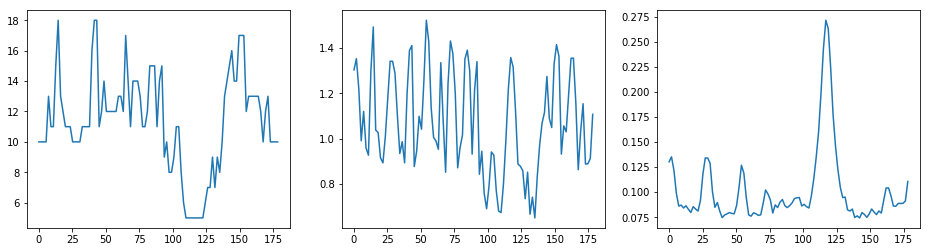

In [143]:
# Plot results. 
# Number of maxima, total intensity of maxima, and score (inten/#) function

score = total_intensity/N_maxima

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.plot(angles,N_maxima)
ax2.plot(angles,total_intensity)
ax3.plot(angles,score)
plt.show()

In [144]:
# Get maxima of scores

sigma = 2
min_diff = 5

score_blurred = gaussian_filter(score,sigma)

score_maxima0 = (score_blurred > np.roll(score_blurred,-1)) & (score_blurred >= np.roll(score_blurred,+1))

coordinates = [('angle',float),('intensity',float)]
score_maxima = PointList(coordinates, dc)

for i in score_maxima0.nonzero()[0]:
    new_point = (angles[i], score_blurred[i])
    score_maxima.add_point(new_point)

score_maxima.sort('intensity')

deletemask = np.zeros(score_maxima.length,dtype=bool)
for i in range(score_maxima.length):
    if not deletemask[i]:
        delete = np.abs(score_maxima.data['angle'][i]-score_maxima.data['angle']) < min_diff
        delete[:i+1]=False
        deletemask = deletemask | delete
score_maxima.remove_points(deletemask)

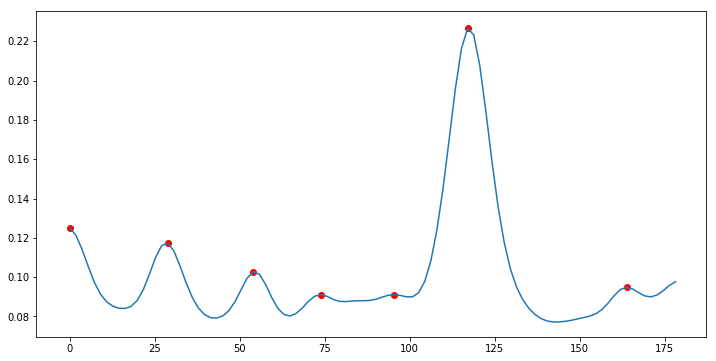

In [145]:
# Plot score and maxima

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(angles, score_blurred)
ax.scatter(score_maxima.data['angle'],score_maxima.data['intensity'],color='r')
plt.show()

In [146]:
# Get initial guess at u angle

score_maxima.sort('intensity')
u_angle0 = score_maxima.data['angle'][0]

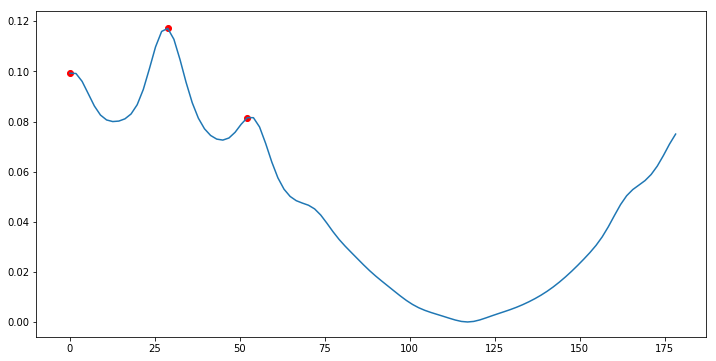

In [147]:
# Damp scores by cosine envelope about the u angle
# Get maxima, plot

sigma = 2
min_diff = 5

score_sin_damped = score_blurred*np.sin((angles-u_angle0)*np.pi/180.)**2

score_maxima0 = (score_sin_damped > np.roll(score_sin_damped,-1)) & (score_sin_damped >= np.roll(score_sin_damped,+1))

coordinates = [('angle',float),('intensity',float)]
score_maxima = PointList(coordinates, dc)

for i in score_maxima0.nonzero()[0]:
    new_point = (angles[i], score_sin_damped[i])
    score_maxima.add_point(new_point)

score_maxima.sort('intensity')

deletemask = np.zeros(score_maxima.length,dtype=bool)
for i in range(score_maxima.length):
    if not deletemask[i]:
        delete = np.abs(score_maxima.data['angle'][i]-score_maxima.data['angle']) < min_diff
        delete[:i+1]=False
        deletemask = deletemask | delete
score_maxima.remove_points(deletemask)

# Plot
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(angles, score_sin_damped)
ax.scatter(score_maxima.data['angle'],score_maxima.data['intensity'],color='r')
plt.show()

In [165]:
# Get initial guess at u angle

score_maxima.sort('intensity')
v_angle0 = score_maxima.data['angle'][0]

In [166]:
print("Initial guess at u and v angles is {} and {}, respectively.".format(u_angle0,v_angle0))

Initial guess at u and v angles is 117.0 and 28.8, respectively.


### Refinement

In [167]:
# Refine the u and v angles

# Params for refinement angles
window_rad_degrees = 8
N_rotations = 50

# Params for histograms
sigma_gaussianblur = 10
min_dist = 10
threshhold = 0.05

angles = np.linspace(-window_rad_degrees,window_rad_degrees,N_rotations)
rotation_degrees = 2*window_rad_degrees/N_rotations
theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

score_maxima.sort('intensity')
angle_guesses = (u_angle0, v_angle0)

# Metrics
N_maxima = np.empty((len(angles),len(angle_guesses)))
total_intensity = np.empty((len(angles),len(angle_guesses)))

t0=time()
for k in range(len(angle_guesses)):
    
    angle_guess = angle_guesses[k]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)
    
    # Initial rotation
    Bragg_peaks_rotating = Bragg_peaks_current_DP.copy()
    theta_i = angles[0]*np.pi/180.
    costheta_i = np.cos(theta_i)
    sintheta_i = np.sin(theta_i)
    for i in range(Bragg_peaks_rotating.length):
        x0 = Bragg_peaks_rotating.data['qx'][i]
        y0 = Bragg_peaks_rotating.data['qy'][i]
        Bragg_peaks_rotating.data['qx'][i] = x0*costheta_i - y0*sintheta_i
        Bragg_peaks_rotating.data['qy'][i] = x0*sintheta_i + y0*costheta_i
    
    for j in range(len(angles)):
        angle = angles[j]

        # Rotate peaks
        for i in range(Bragg_peaks_rotating.length):
            x0 = Bragg_peaks_rotating.data['qx'][i]
            y0 = Bragg_peaks_rotating.data['qy'][i]
            Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
            Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta

        # Get projected histogram
        bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
        projected_histogram = np.zeros_like(bins)
        for i in range(Bragg_peaks_rotating.length):
            projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1
            
        histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)
        
        # Get maxima
        maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))
        
        coordinates = [('angle',float),('bin',int),('intensity',float)]
        maxima = PointList(coordinates, dc)
        
        for i in maxima0.nonzero()[0]:
            new_point = (angle, bins[i], histogram_blurred[i])
            maxima.add_point(new_point)

        maxima.sort('intensity')
        
        # Remove maxima below threshhold
        max_intensity = maxima.data['intensity'][0]
        deletemask = np.zeros(maxima.length,dtype=bool)
        for i in range(maxima.length):
            if maxima.data['intensity'][i]/max_intensity < threshhold:
                deletemask[i] = True
        maxima.remove_points(deletemask)

        # Remove maxima which are too close together
        deletemask = np.zeros(maxima.length,dtype=bool)
        for i in range(maxima.length):
            if not deletemask[i]:
                delete = np.abs(maxima.data['bin'][i]-maxima.data['bin']) < min_dist
                delete[:i+1]=False
                deletemask = deletemask | delete
        maxima.remove_points(deletemask)

        # Calculat metrics
        N_maxima[j][k] = maxima.length
        total_intensity[j][k] = np.sum(maxima.data['intensity'])
        
        maxima=None
        collect()
        
t=time()-t0
print("Time elapsed: {}h {}m {}s".format(int(t/3600),int(t/60)%60,int(t)%60))

Time elapsed: 0h 0m 6s


Angle = 117.0


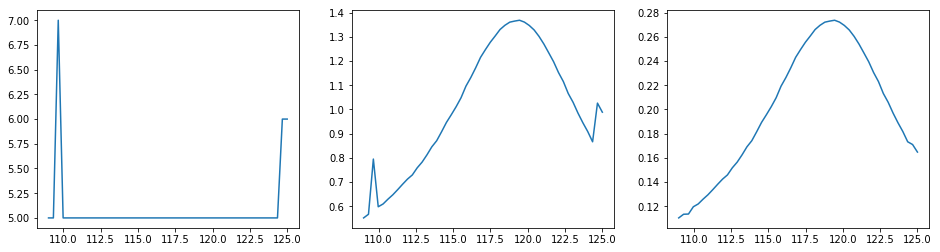

Angle = 28.8


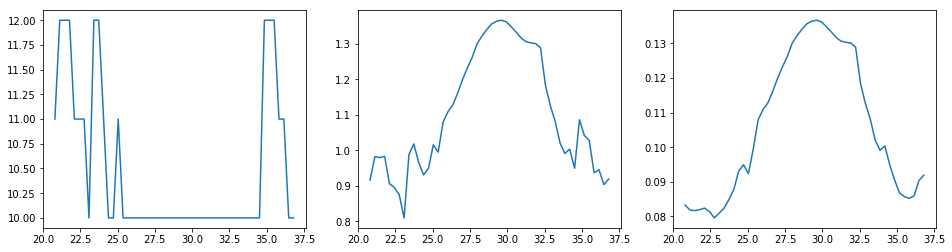

In [168]:
# Plot results. 
# Number of maxima, total intensity of maxima, and score (inten/#) function

scores = total_intensity/N_maxima

for i in range(len(angle_guesses)):
    
    print("Angle = {}".format(angle_guesses[i]))
    angles = np.linspace(angle_guesses[i]-window_rad_degrees,angle_guesses[i]+window_rad_degrees,N_rotations)
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
    ax1.plot(angles,N_maxima[:,i])
    ax2.plot(angles,total_intensity[:,i])
    ax3.plot(angles,scores[:,i])
    plt.show()

In [169]:
# Get maxima of scores

sigma = 2
min_diff = 5

scores = total_intensity/N_maxima

scores_blurred = np.empty_like(scores)

coordinates = [('angle',float),('intensity',float)]
refined_score_maxima = [PointList(coordinates, dc), PointList(coordinates, dc)]

for j in range(len(angle_guesses)):

    angle_guess = angle_guesses[j]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)
    
    scores_blurred[:,j] = gaussian_filter(scores[:,j],sigma)
    
    refined_score_maxima0 = (scores_blurred[:,j] > np.roll(scores_blurred[:,j],-1)) & (scores_blurred[:,j] >= np.roll(scores_blurred[:,j],+1))
    
    for i in refined_score_maxima0.nonzero()[0]:
        new_point = (angles[i], scores_blurred[i,j])
        refined_score_maxima[j].add_point(new_point)
    
    refined_score_maxima[j].sort('intensity')
    
    deletemask = np.zeros(refined_score_maxima[j].length,dtype=bool)
    for i in range(refined_score_maxima[j].length):
        if not deletemask[i]:
            delete = np.abs(refined_score_maxima[j].data['angle'][i]-refined_score_maxima[j].data['angle']) < min_diff
            delete[:i+1]=False
            deletemask = deletemask | delete
    refined_score_maxima[j].remove_points(deletemask)

Angle = 117.0


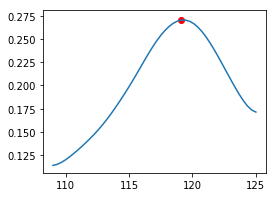

Angle = 28.8


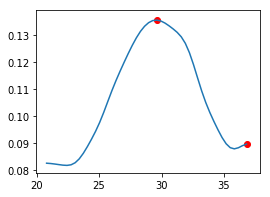

In [170]:
# Plot score and maxima

for j in range(len(angle_guesses)):

    angle_guess = angle_guesses[j]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)

    print("Angle = {}".format(angle_guess))
    fig,ax = plt.subplots(figsize=(4,3))
    ax.plot(angles, scores_blurred[:,j])
    ax.scatter(refined_score_maxima[j].data['angle'],refined_score_maxima[j].data['intensity'],color='r')
    plt.show()

In [171]:
# Get u and v angles

refined_score_maxima[0].sort('intensity')
refined_score_maxima[1].sort('intensity')
u_angle = refined_score_maxima[0].data['angle'][0]
v_angle = refined_score_maxima[1].data['angle'][0]

print("u and v angles are {} and {} degrees, respectively.".format(u_angle, v_angle))

u and v angles are 119.12244897959184 and 29.61632653061224 degrees, respectively.


### Get lattice vector lengths

In [172]:
# Parameters

sigma_gaussianblur = 10
min_dist = 10
threshhold = 0.05

coordinates = [('bin',float),('intensity',float)]
u_maxima = PointList(coordinates, dc)
v_maxima = PointList(coordinates, dc)

In [173]:
# Get peaks when projecting down u

Bragg_peaks_rotating = Bragg_peaks_current_DP.copy()
theta = u_angle*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)
for i in range(Bragg_peaks_rotating.length):
    x0 = Bragg_peaks_rotating.data['qx'][i]
    y0 = Bragg_peaks_rotating.data['qy'][i]
    Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
# Get projected histogram
bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
projected_histogram = np.zeros_like(bins)
for i in range(Bragg_peaks_rotating.length):
    projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1

histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)

# Get maxima
maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))

for i in maxima0.nonzero()[0]:
    new_point = (bins[i], histogram_blurred[i])
    u_maxima.add_point(new_point)

u_maxima.sort('intensity')

# Remove maxima below threshhold
max_intensity = u_maxima.data['intensity'][0]
deletemask = np.zeros(u_maxima.length,dtype=bool)
for i in range(u_maxima.length):
    if u_maxima.data['intensity'][i]/max_intensity < threshhold:
        deletemask[i] = True
u_maxima.remove_points(deletemask)

# Remove maxima which are too close together
deletemask = np.zeros(u_maxima.length,dtype=bool)
for i in range(u_maxima.length):
    if not deletemask[i]:
        delete = np.abs(u_maxima.data['bin'][i]-u_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
u_maxima.remove_points(deletemask)

In [174]:
# Get u projected spacing

thresh=1.5

u_maxima.sort('bin')
diffs = u_maxima.data['bin'][:-1]-u_maxima.data['bin'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
u_projected_spacing = np.average(diffs)

In [175]:
# Get peaks when projecting down v

Bragg_peaks_rotating = Bragg_peaks_current_DP.copy()
theta = v_angle*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)
for i in range(Bragg_peaks_rotating.length):
    x0 = Bragg_peaks_rotating.data['qx'][i]
    y0 = Bragg_peaks_rotating.data['qy'][i]
    Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
# Get projected histogram
bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
projected_histogram = np.zeros_like(bins)
for i in range(Bragg_peaks_rotating.length):
    projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1

histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)

# Get maxima
maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))

for i in maxima0.nonzero()[0]:
    new_point = (bins[i], histogram_blurred[i])
    v_maxima.add_point(new_point)

v_maxima.sort('intensity')

# Remove maxima below threshhold
max_intensity = v_maxima.data['intensity'][0]
deletemask = np.zeros(v_maxima.length,dtype=bool)
for i in range(v_maxima.length):
    if v_maxima.data['intensity'][i]/max_intensity < threshhold:
        deletemask[i] = True
v_maxima.remove_points(deletemask)

# Remove maxima which are too close together
deletemask = np.zeros(v_maxima.length,dtype=bool)
for i in range(v_maxima.length):
    if not deletemask[i]:
        delete = np.abs(v_maxima.data['bin'][i]-v_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
v_maxima.remove_points(deletemask)

In [176]:
# Get v spacing

thresh = 1.5

v_maxima.sort('bin')
diffs = v_maxima.data['bin'][:-1]-v_maxima.data['bin'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
v_projected_spacing = np.average(diffs)

In [177]:
# Get u and v lengths

sin_uv = np.sin(np.abs(u_angle-v_angle)*np.pi/180.)
u_length = v_projected_spacing / sin_uv
v_length = u_projected_spacing / sin_uv

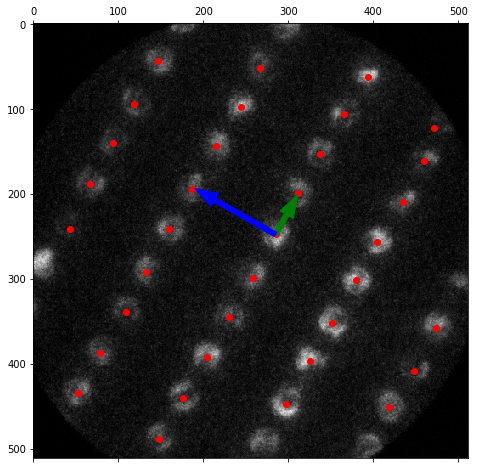

In [224]:
# Show

ind = np.argmin((Bragg_peaks_current_DP.data['qx']-dc.Q_Nx/2)**2 + (Bragg_peaks_current_DP.data['qy']-dc.Q_Ny/2)**2)
x0,y0 = Bragg_peaks_current_DP.data['qx'][ind],Bragg_peaks_current_DP.data['qy'][ind]

u_dx = np.cos(u_angle*np.pi/180.)*u_length
u_dy = np.sin(u_angle*np.pi/180.)*u_length
v_dx = np.cos(v_angle*np.pi/180.)*v_length
v_dy = np.sin(v_angle*np.pi/180.)*v_length

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,-u_dx,-u_dy, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,-v_dx,-v_dy, color='blue',width=6,length_includes_head=True)
plt.show()

### Save lattice vectors

In [185]:
# Make pointlist

coordinates = [('angle',float),('length',float)]
lattice_vectors = PointList(coordinates, dc, name='lattice_vectors')
lattice_vectors.add_point((u_angle,u_length))
lattice_vectors.add_point((v_angle,v_length))

In [186]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
py4DSTEM.readwrite.save_dataobject(lattice_vectors,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5...
Writing metadata...
Done.


In [187]:
# # Save

# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
# py4DSTEM.readwrite.save_dataobject(lattice_vectors,savepath)